In [ ]:
# A.1. Download the data

In [1]:
from fastai.vision.all import *
from google.colab import drive

drive.mount('/content/drive')

path = Path('/content/drive/MyDrive/ADA 447 Midterm Project/Data')

# A.1.1. Inspect the data layout
print(path.ls())


Mounted at /content/drive
[Path('/content/drive/MyDrive/ADA 447 Midterm Project/Data/normal'), Path('/content/drive/MyDrive/ADA 447 Midterm Project/Data/glioma_tumor'), Path('/content/drive/MyDrive/ADA 447 Midterm Project/Data/pituitary_tumor'), Path('/content/drive/MyDrive/ADA 447 Midterm Project/Data/meningioma_tumor')]


In [2]:
from sklearn.model_selection import train_test_split

image_paths = get_image_files(path)

# train/test
train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)

train_paths, valid_paths = train_test_split(train_paths, test_size=0.2, random_state=42)

# Multicategory block is used to avoid the model predictions for the irrelevant images.

In [ ]:
# A.1.2. Decide how to create the datablock
# A.2. Create the DataBlock and dataloaders
# A.2.1 Define the blocks
# A.2.2 Define the means of getting data into DataBlock
# A.2.3 Define how to get the attributes
# A.2.4  Define data transformations

In [3]:
def get_label(x):
    return [x.parent.name]

# Multicategory DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224) # Augmentation + resizing
)

# A.3. Inspect the DataBlock via dataloader
dls = dblock.dataloaders(path, bs=16)

print(dls.vocab)

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [ ]:
from collections import Counter

train_labels = [path.parent.name for path in get_image_files(path) if path not in valid_paths]
print(Counter(train_labels))


Counter({'glioma_tumor': 743, 'meningioma_tumor': 737, 'pituitary_tumor': 702, 'normal': 356})


Batch size: 16
Classes: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
Training samples: 2477
Validation samples: 619
Test samples: 310


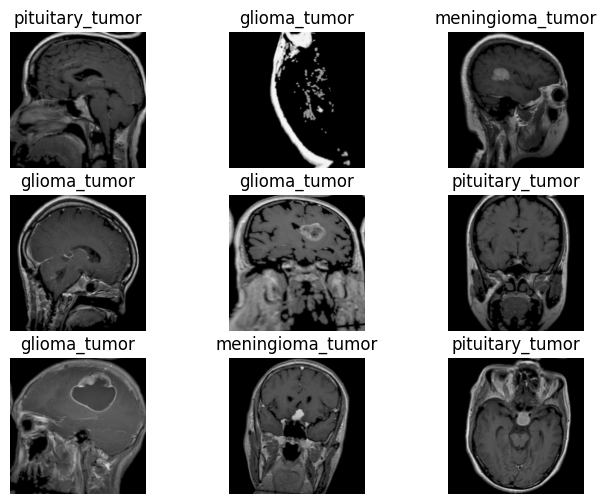

In [4]:
# Batch
print(f"Batch size: {dls.bs}")
print(f"Classes: {dls.vocab}")
print(f"Training samples: {len(dls.train_ds)}")
print(f"Validation samples: {len(dls.valid_ds)}")
test_dl = dls.test_dl(test_paths)
print(f"Test samples: {len(test_dl.items)}")
# A.3.1 Show  batch: dataloader.show_batch()
# A.3.2 Check the labels
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
# A.3.3 Summarize the DataBlock: dataloader.summary(path/data)
dblock.summary(path)

Setting-up type transforms pipelines
Found 3096 items
2 datasets of sizes 2477,619
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/ADA 447 Midterm Project/Data/pituitary_tumor/P_463.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: get_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
    starting from
      /content/drive/MyDrive/ADA 447 Midterm Project/Data/pituitary_tumor/P_463.jpg
    applying get_label gives
      [pituitary_tumor]
    applying MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorMultiCategory([3])
    applying OneHotEncode -- {'c': None} gives
      TensorMultiCategory([0., 0., 0., 1.])

Final sample: (PILImage mode=RGB size=256x25

In [ ]:
# multicategoryblock with resnet

In [ ]:
"""
A.4. Train a simple model
A.4.1 Create a benchmark
A.4.2 Interpret the model
A.4.3 Confusion matrix
"""


# ResNet18

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

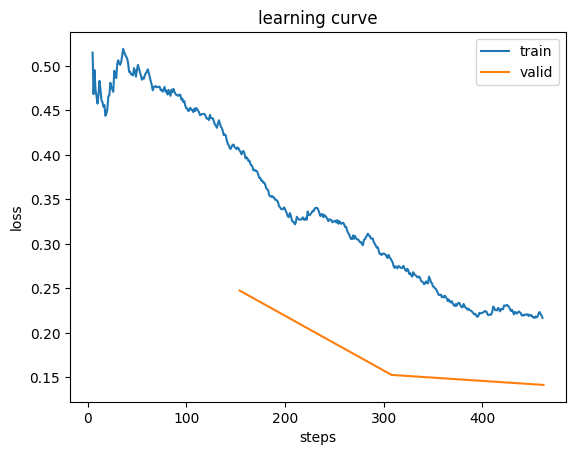

In [ ]:
# finetune, benchmark
learn = vision_learner(dls, resnet18, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=0.001)
learn.recorder.plot_loss()

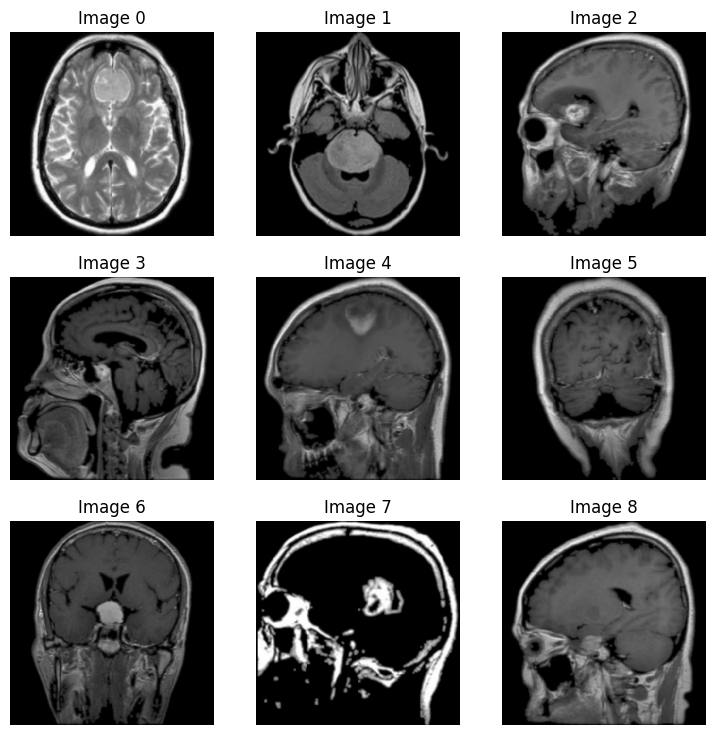

In [ ]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

preds, targs = learn.get_preds()

pred_labels = (preds > 0.2).int().numpy()
true_labels = targs.int().numpy()

cms = multilabel_confusion_matrix(true_labels, pred_labels)

for i, cm in enumerate(cms):
    print(f"Class {i} confusion matrix:\n{cm}\n")

Class 0 confusion matrix:
[[400  42]
 [ 10 167]]

Class 1 confusion matrix:
[[360  84]
 [  7 168]]

Class 2 confusion matrix:
[[486  40]
 [  0  93]]

Class 3 confusion matrix:
[[421  24]
 [  7 167]]



<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

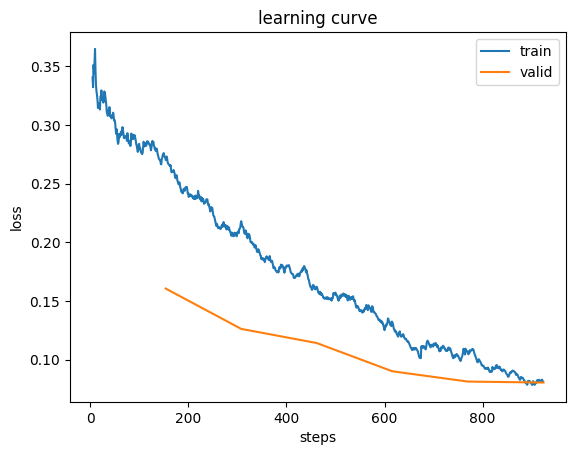

In [ ]:
# finetune + freezing
learn = vision_learner(dls, resnet18, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(6, base_lr=0.001, freeze_epochs=4)
learn.recorder.plot_loss()

# ResNet50

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

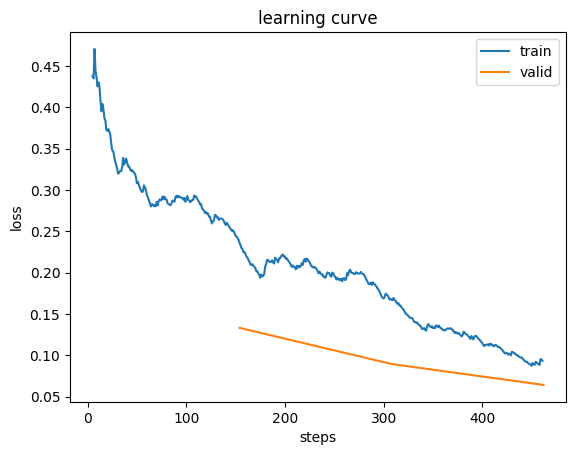

In [ ]:
# finetune, benchmark
learn = vision_learner(dls, resnet50, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=0.01)
learn.recorder.plot_loss()

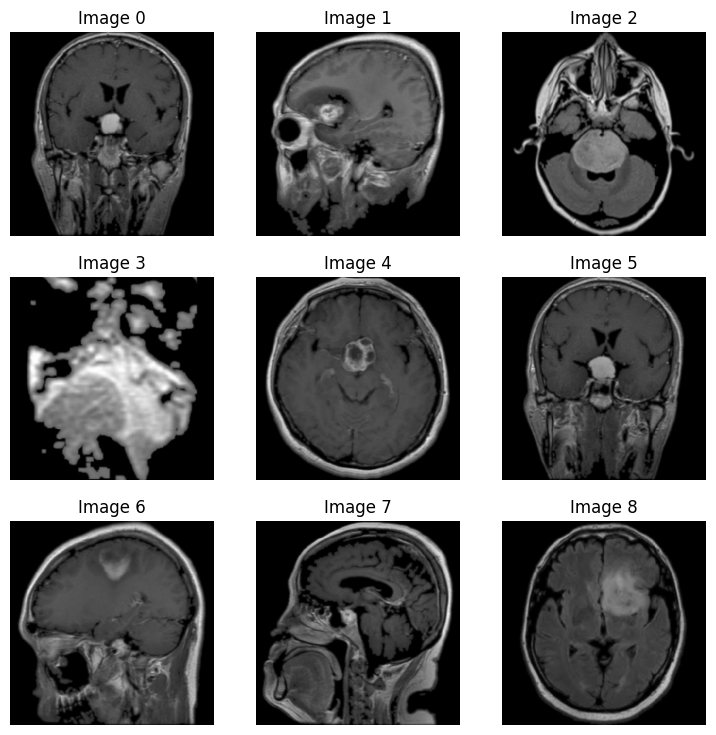

In [ ]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

preds, targs = learn.get_preds()

pred_labels = (preds > 0.2).int().numpy()
true_labels = targs.int().numpy()

cms = multilabel_confusion_matrix(true_labels, pred_labels)

for i, cm in enumerate(cms):
    print(f"Class {i} confusion matrix:\n{cm}\n")

Class 0 confusion matrix:
[[415  27]
 [  3 174]]

Class 1 confusion matrix:
[[415  29]
 [  3 172]]

Class 2 confusion matrix:
[[526   0]
 [  1  92]]

Class 3 confusion matrix:
[[439   6]
 [  5 169]]



<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

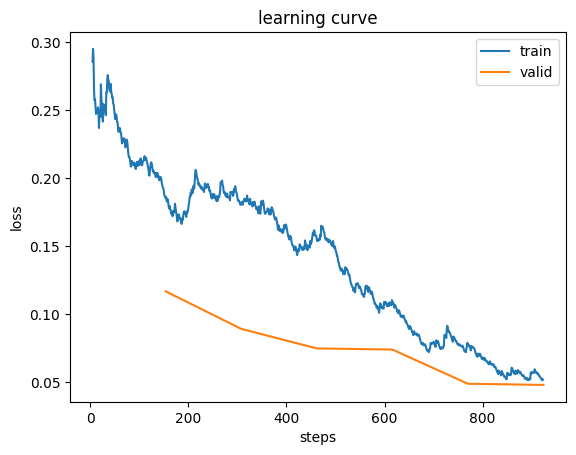

In [ ]:
# finetune + freezing
learn = vision_learner(dls, resnet50, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(6, base_lr=0.01, freeze_epochs=4)
learn.recorder.plot_loss()

In [ ]:
"""
B.1. Learning Rate Finder
B.1.1 Big lr: Convergence will be poor, if not impossible
B.1.2 Small lr: Convergence will be slow, takes too much epochs, hence overfitting

B.2. Finder Algorithm:
B.2.1 Start with a very very low lr
B.2.2 train one batch with lr, record loss
B.2.3 increare lr to 2*lr
B.2.4 train one batch with 2*lr, record the new loss
B.2.5 if the new loss is smaller than old loss, continue increasing
"""

# ResNet18

Minimum/10: 1.00e-02, steepest point: 1.32e-02


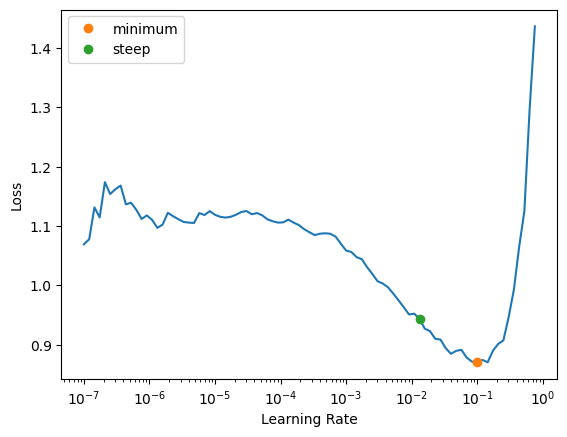

In [ ]:
# lr finder
learn = vision_learner(dls, resnet18, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

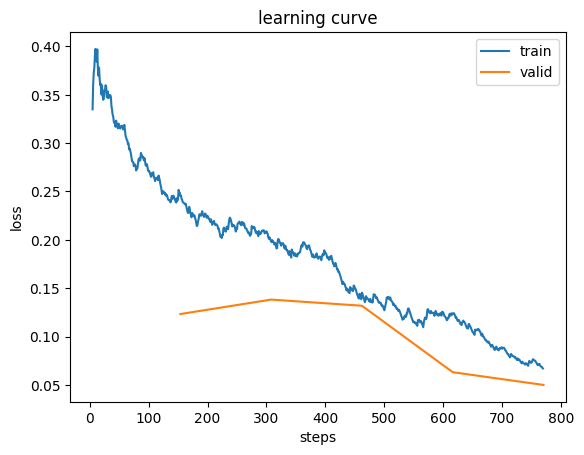

In [ ]:
# finetune with decided lr
learn = vision_learner(dls, resnet18, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(5, base_lr=1e-2)
learn.recorder.plot_loss()

# ResNet50

Minimum/10: 1.45e-02, steepest point: 2.09e-03


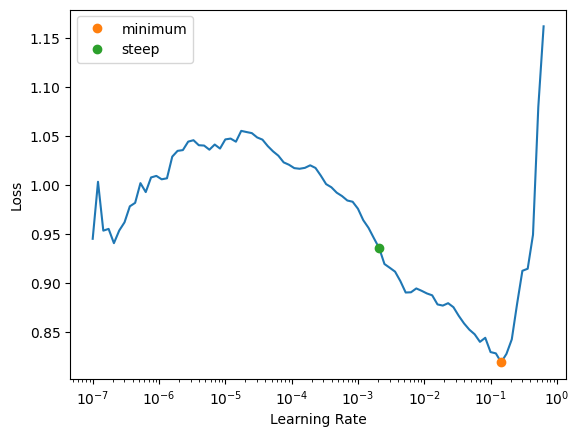

In [ ]:
# lr finder
learn = vision_learner(dls, resnet50, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

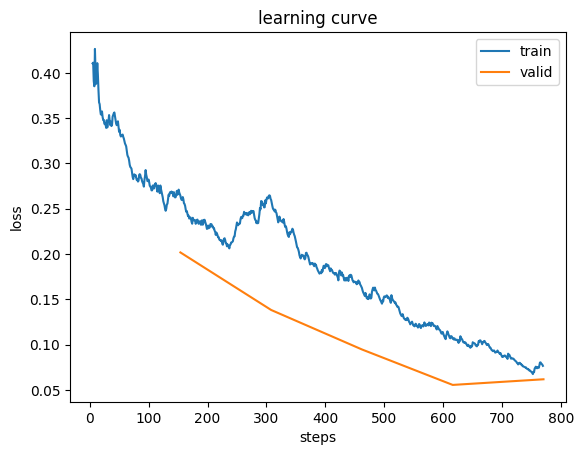

In [ ]:
# finetune with decided lr
learn = vision_learner(dls, resnet50, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(5, base_lr=1.5e-2)
learn.recorder.plot_loss()

In [ ]:
"""
B.3. Transfer Learning (One or more final linear layers)
B.3. Old final linear layer F of size mxn (n is the number of classes)
B.3. Replace the trained F with a new one F' of size mxk (k is the number of classes in the new task)
B.3. Only train F' while using the previous weights unchanged (called Freezing)
B.3. Continue training all the weights F' and previous weights (called Unfreezing)
"""

# ResNet18

In [ ]:
# Unfreezing and transfer learning with fit one cycle (not with finetune)

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fit_one_cycle(5, 1e-2)

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.00013182566908653826)

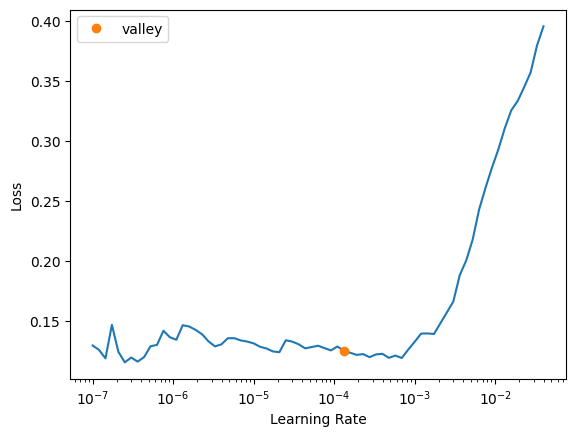

In [ ]:
learn.lr_find()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

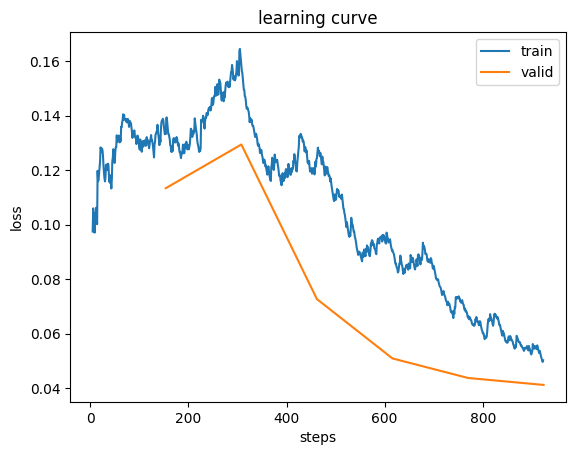

In [ ]:
# fit one cycle with decided lr
learn.fit_one_cycle(6, lr_max=1.3e-4)
learn.recorder.plot_loss()

# ResNet50

In [ ]:
learn = vision_learner(dls, resnet50, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fit_one_cycle(5, 1.5e-2)

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.0004786300996784121)

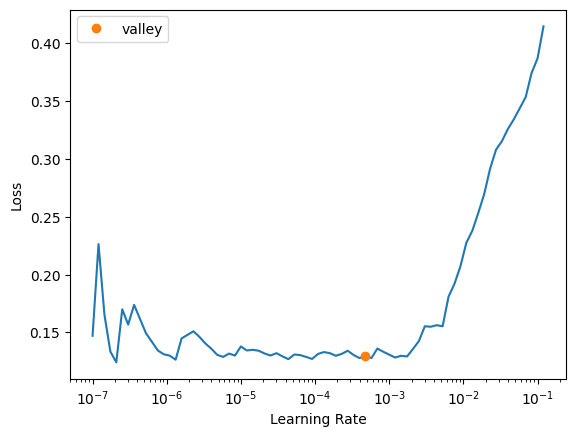

In [ ]:
learn.lr_find()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

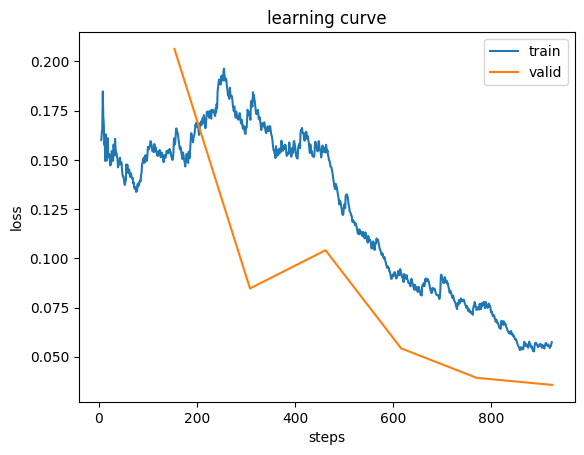

In [ ]:
# fit one cycle with decided lr
learn.fit_one_cycle(6, lr_max=4.3e-4)
learn.recorder.plot_loss()

In [ ]:
"""
B.4. Discriminative Learning Rates
B.4.1. The early weights are already trained well, we don't need to tweak them much
B.4.2. But the newly added layer contains random weights, so it needs larger tweak to get better suited
B.4.3. Early layers learn simpler (i.e. more general) properties
B.4.4. Whereas, later layers learn mode complex (i.e. more specific) properties
B.4.5. More specific finding might not be that helpful in our different task
B.4.6. So: We can change the weight of the further layers more liberal, compare to the early layers
B.4.7. Fastai uses ULMFIT approach for NLP transfer learning, via lr_max=slice(first_lr,last_lr)
"""

# ResNet18

In [ ]:
# one more step using discriminative learning rates: The deepest layers of our pretrained model might not need as high a learning rate as the last ones,
# so we should probably use different learning rates for those—this is known as using discriminative learning rates.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

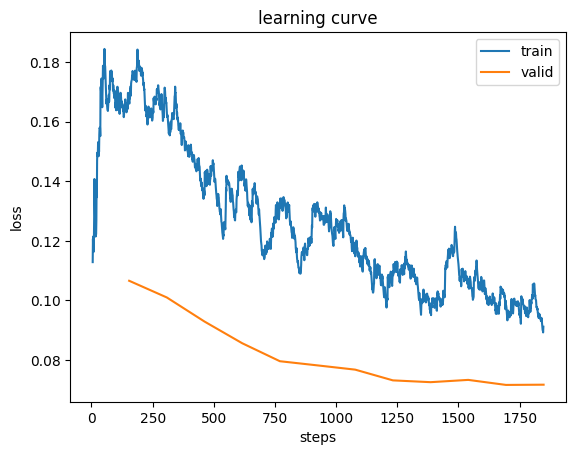

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fit_one_cycle(3, 1e-2)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1.3e-4))
learn.recorder.plot_loss()

# ResNet50

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

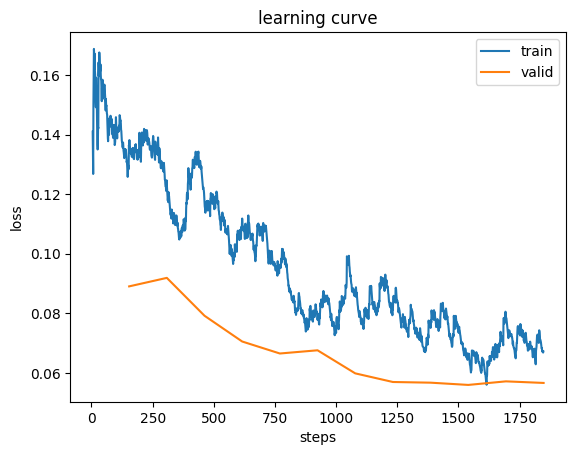

In [ ]:
learn = vision_learner(dls, resnet50, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn.fit_one_cycle(5, 1.5e-2)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,4.3e-4))
learn.recorder.plot_loss()

#ResNet18

In [ ]:
# testing and results of the last achieved resnet18 model version

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

test_dl = learn.dls.test_dl(test_paths, with_labels=True)

preds, targets = learn.get_preds(dl=test_dl)

best_thresh = 0.0
best_f1 = 0.0
for t in [i/100 for i in range(10, 90, 5)]:
    f1 = f1_score(targets, (preds > t).int(), average='macro')
    if f1 > best_f1:
        best_f1, best_thresh = f1, t
print(f"Best Threshold: {best_thresh}, Best F1: {best_f1:.4f}")


Best Threshold: 0.55, Best F1: 0.9739


In [ ]:
threshold = 0.55
pred_labels = (preds > threshold).int()

avg_confidence = preds.mean().item()
print(f"Average confidence: {avg_confidence:.4f}")

acc = accuracy_score(targets, pred_labels)
f1 = f1_score(targets, pred_labels, average='macro')
precision = precision_score(targets, pred_labels, average='macro')
recall = recall_score(targets, pred_labels, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

class_names = learn.dls.vocab
print("\nClassification Report:")
print(classification_report(targets, pred_labels, target_names=class_names))

import pandas as pd
df_report = classification_report(targets, pred_labels, target_names=class_names, output_dict=True)
print(pd.DataFrame(df_report).transpose())


Average confidence: 0.2478
Accuracy: 0.9645
F1 Score: 0.9739
Precision: 0.9807
Recall: 0.9676

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.93      0.96        90
meningioma_tumor       0.95      0.96      0.96        80
          normal       0.98      1.00      0.99        61
 pituitary_tumor       1.00      0.97      0.99        79

       micro avg       0.98      0.96      0.97       310
       macro avg       0.98      0.97      0.97       310
    weighted avg       0.98      0.96      0.97       310
     samples avg       0.96      0.96      0.96       310

                  precision    recall  f1-score  support
glioma_tumor       0.988235  0.933333  0.960000     90.0
meningioma_tumor   0.950617  0.962500  0.956522     80.0
normal             0.983871  1.000000  0.991870     61.0
pituitary_tumor    1.000000  0.974684  0.987179     79.0
micro avg          0.980328  0.964516  0.972358    310.0
macro avg      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


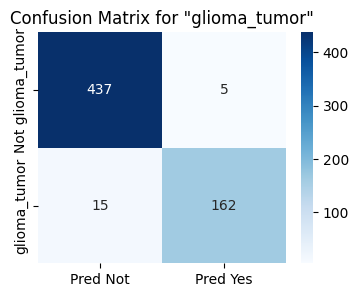

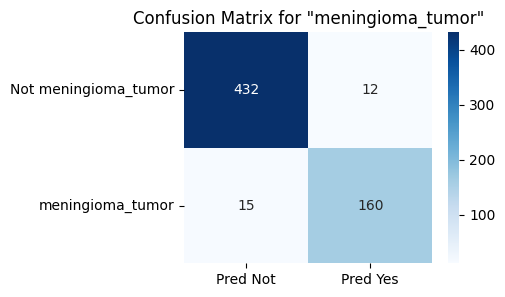

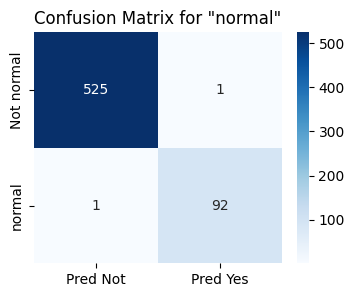

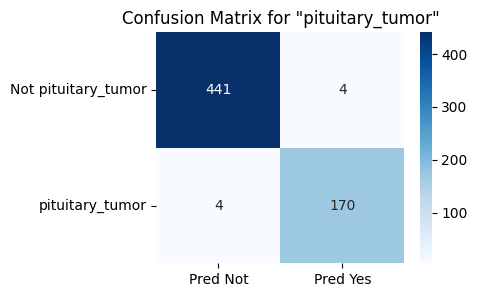

In [ ]:
# resnet18 results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix

preds, targs = learn.get_preds()
preds_binary = (preds > 0.5).int()

mcm = multilabel_confusion_matrix(targs, preds_binary)

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm, index=["Not " + dls.vocab[i], dls.vocab[i]],
                         columns=["Pred Not", "Pred Yes"])
    plt.figure(figsize=(4,3))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for "{dls.vocab[i]}"')
    plt.show()

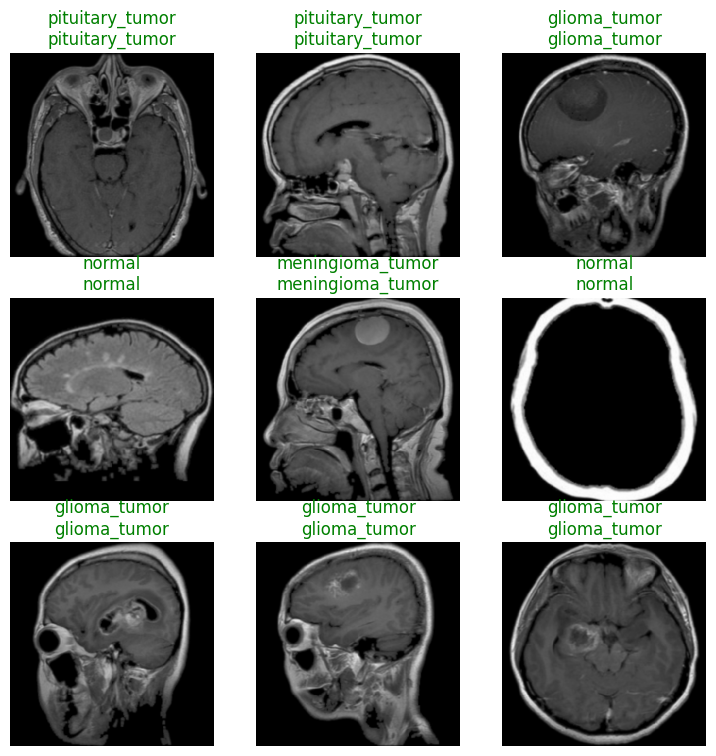

In [ ]:
# resnet18 results
learn.show_results()

In [ ]:
learn.export('/content/drive/MyDrive/model_multicategoryblock_resnet18_v3.pkl')

#ResNet50

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

test_dl = learn.dls.test_dl(test_paths, with_labels=True)

preds, targets = learn.get_preds(dl=test_dl)

best_thresh = 0.0
best_f1 = 0.0
for t in [i/100 for i in range(10, 90, 5)]:
    f1 = f1_score(targets, (preds > t).int(), average='macro')
    if f1 > best_f1:
        best_f1, best_thresh = f1, t
print(f"Best Threshold: {best_thresh}, Best F1: {best_f1:.4f}")

Best Threshold: 0.55, Best F1: 0.9895


In [ ]:
threshold = 0.55
pred_labels = (preds > threshold).int()

avg_confidence = preds.mean().item()
print(f"Average confidence: {avg_confidence:.4f}")

acc = accuracy_score(targets, pred_labels)
f1 = f1_score(targets, pred_labels, average='macro')
precision = precision_score(targets, pred_labels, average='macro')
recall = recall_score(targets, pred_labels, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

class_names = learn.dls.vocab
print("\nClassification Report:")
print(classification_report(targets, pred_labels, target_names=class_names))

import pandas as pd
df_report = classification_report(targets, pred_labels, target_names=class_names, output_dict=True)
print(pd.DataFrame(df_report).transpose())


Average confidence: 0.2509
Accuracy: 0.9839
F1 Score: 0.9895
Precision: 0.9940
Recall: 0.9850

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.98      0.98        90
meningioma_tumor       0.99      0.97      0.98        80
          normal       1.00      1.00      1.00        61
 pituitary_tumor       1.00      0.99      0.99        79

       micro avg       0.99      0.98      0.99       310
       macro avg       0.99      0.99      0.99       310
    weighted avg       0.99      0.98      0.99       310
     samples avg       0.98      0.98      0.98       310

                  precision    recall  f1-score  support
glioma_tumor       0.988764  0.977778  0.983240     90.0
meningioma_tumor   0.987342  0.975000  0.981132     80.0
normal             1.000000  1.000000  1.000000     61.0
pituitary_tumor    1.000000  0.987342  0.993631     79.0
micro avg          0.993485  0.983871  0.988655    310.0
macro avg      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


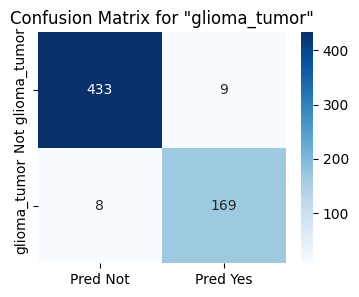

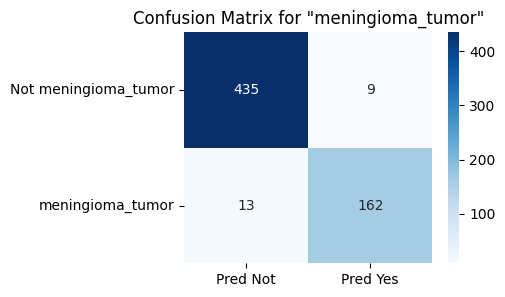

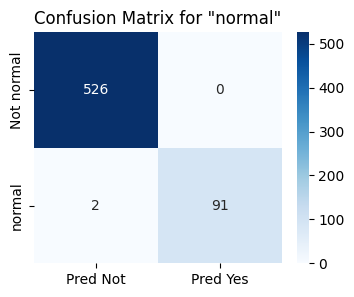

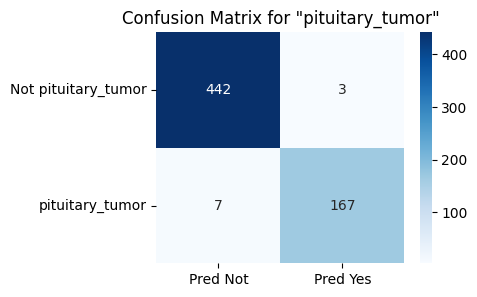

In [ ]:
# resnet50 results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix

preds, targs = learn.get_preds()
preds_binary = (preds > 0.5).int()

mcm = multilabel_confusion_matrix(targs, preds_binary)

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm, index=["Not " + dls.vocab[i], dls.vocab[i]],
                         columns=["Pred Not", "Pred Yes"])
    plt.figure(figsize=(4,3))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for "{dls.vocab[i]}"')
    plt.show()

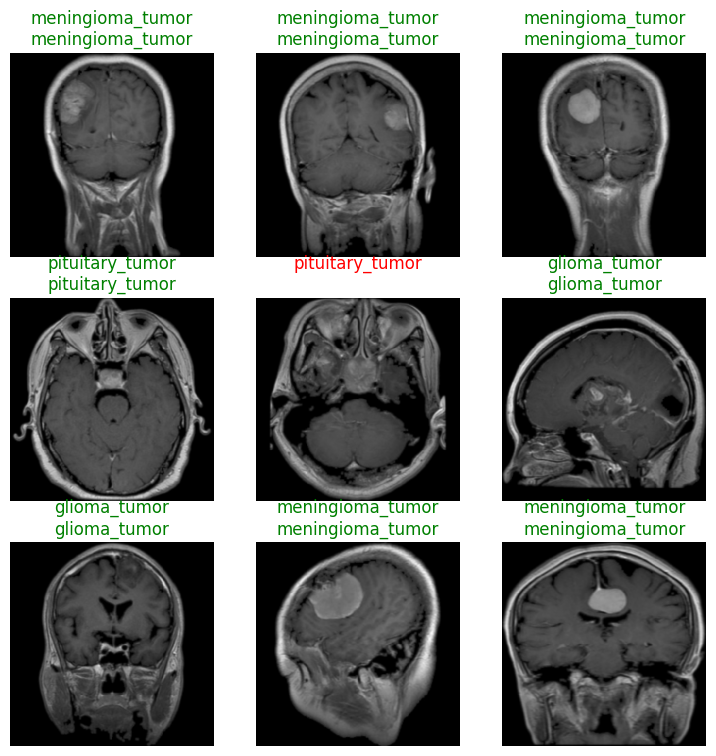

In [ ]:
# resnet50 results
learn.show_results()

In [ ]:
learn.export('/content/drive/MyDrive/model_multicategoryblock_resnet50_v3.pkl')

# Mixed precision with fp16 to observe the effect of usage it.

In [ ]:
# B.6. Model Capacity

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 50.8MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

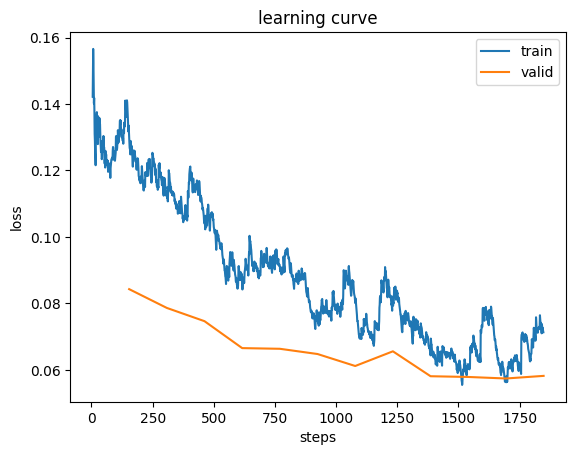

In [5]:
learn = vision_learner(dls, resnet50, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))
learn = learn.to_fp16()
learn.fit_one_cycle(5, 1.5e-2)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,4.3e-4))
learn.recorder.plot_loss()

# CategoryBlock is tried only to observe the performance knowing it does not avoid the model predictions for the irrelevant images.

In [ ]:
from fastai.vision.all import *

def get_label(x):
    return x.parent.name

# Category DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224) # Augmentation + resizing
)

# A.3. Inspect the DataBlock via dataloader
dls = dblock.dataloaders(path, bs=16)

print(dls.vocab)


['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


Batch size: 16
Classes: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
Training samples: 2477
Validation samples: 619
Test samples: 310


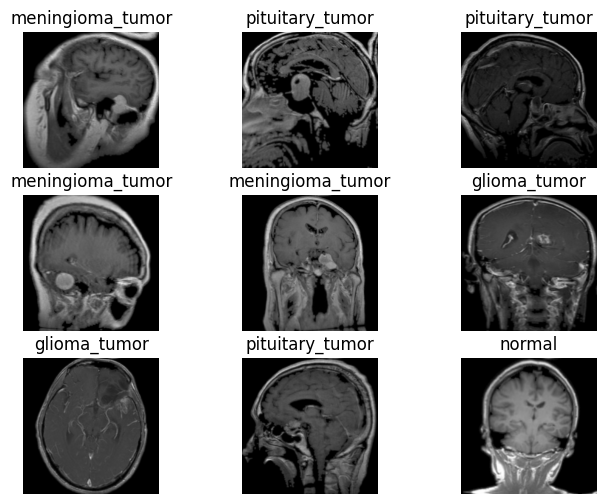

In [ ]:
# Batch
print(f"Batch size: {dls.bs}")
print(f"Classes: {dls.vocab}")
print(f"Training samples: {len(dls.train_ds)}")
print(f"Validation samples: {len(dls.valid_ds)}")
test_dl = dls.test_dl(test_paths)
print(f"Test samples: {len(test_dl.items)}")
# A.3.1 Show  batch: dataloader.show_batch()
# A.3.2 Check the labels
dls.show_batch(max_n=9, figsize=(8,6))

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

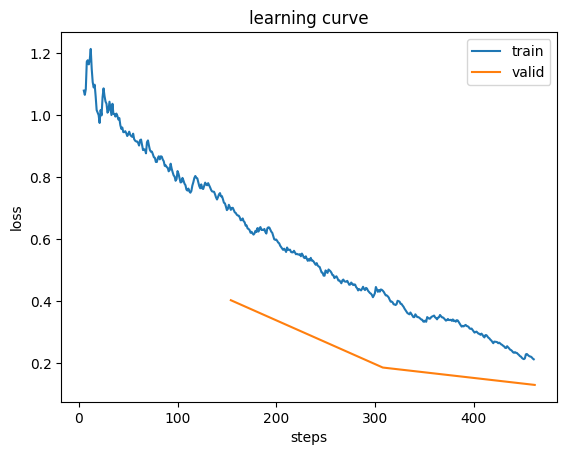

In [ ]:
# finetune, benchmark
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(3, base_lr=0.01)
learn.recorder.plot_loss()

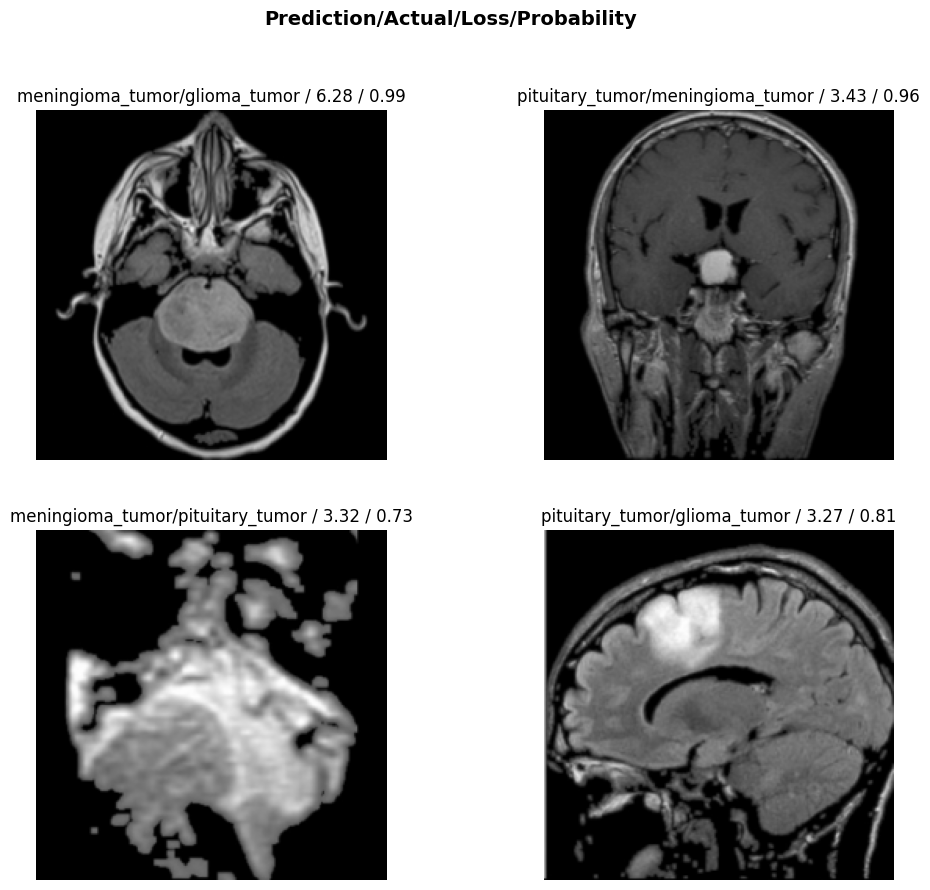

In [ ]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(12,10))

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

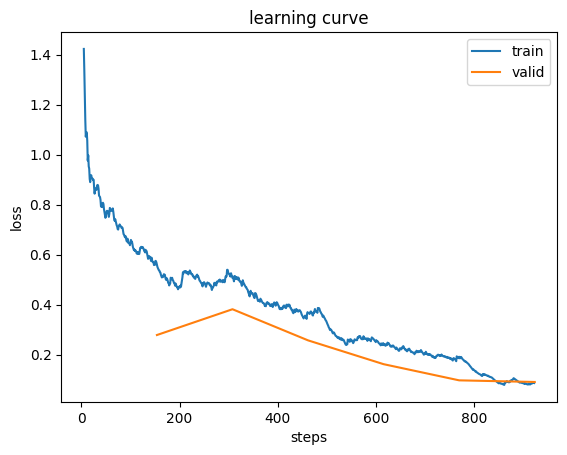

In [ ]:
# finetune + freezing
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(6, base_lr=0.01, freeze_epochs=4)
learn.recorder.plot_loss()

Minimum/10: 1.00e-02, steepest point: 8.32e-04


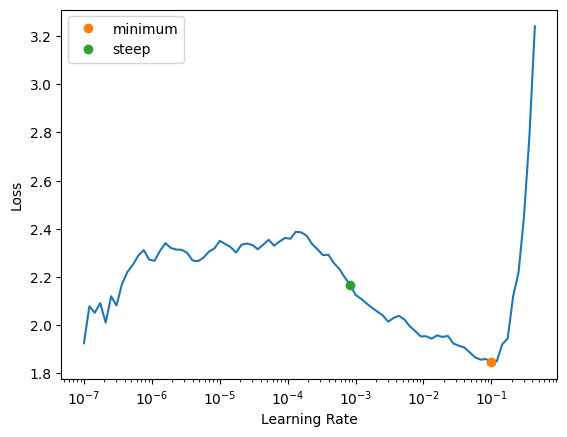

In [ ]:
# lr finder
learn = vision_learner(dls, resnet50, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

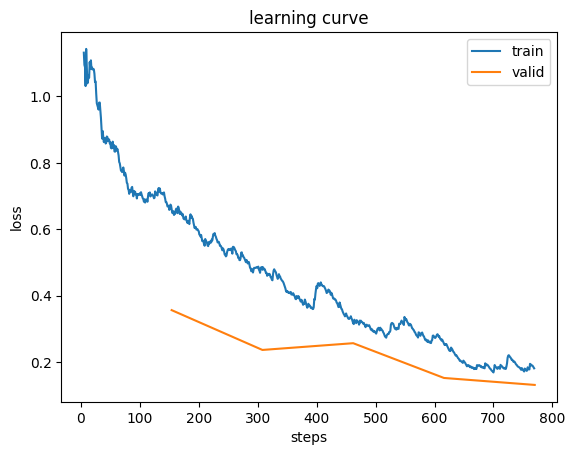

In [ ]:
# finetune with decided lr
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(5, base_lr=1e-2)
learn.recorder.plot_loss()

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fit_one_cycle(5, 1e-2)

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=2.0892961401841603e-05)

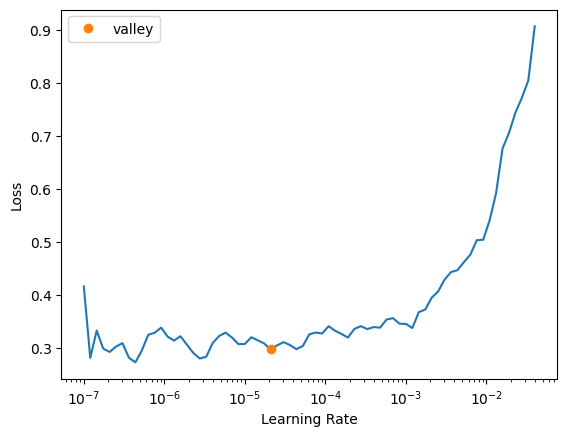

In [ ]:
learn.lr_find()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

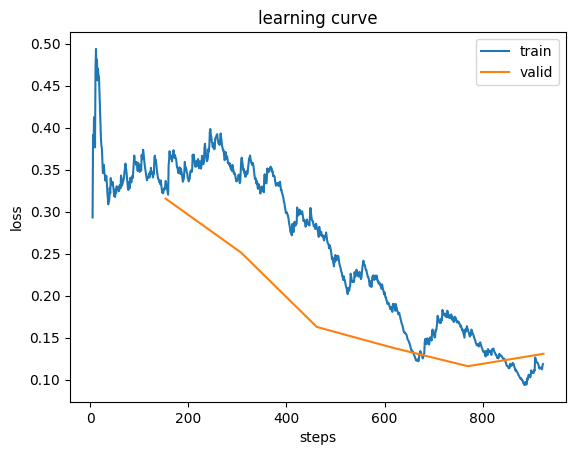

In [ ]:
# fit one cycle with decided lr
learn.fit_one_cycle(6, lr_max=2e-4)
learn.recorder.plot_loss()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

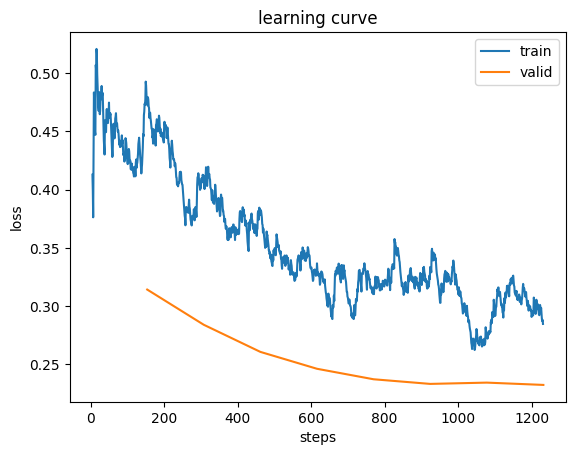

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fit_one_cycle(3, 1e-2)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6,1.2e-4))
learn.recorder.plot_loss()

Preds: tensor([[2.8878e-05, 1.4247e-04, 9.5752e-05, 9.9973e-01],
        [7.5920e-01, 2.4025e-01, 8.2498e-06, 5.4415e-04],
        [1.9981e-05, 1.8854e-04, 1.2765e-04, 9.9966e-01],
        ...,
        [1.4709e-02, 9.8488e-01, 5.5152e-08, 4.1195e-04],
        [8.1518e-04, 9.9912e-01, 4.3788e-06, 5.8760e-05],
        [9.9884e-01, 1.0733e-03, 3.3249e-05, 5.5675e-05]])
Predicted classes: tensor([3, 0, 3, 0, 1, 3, 1, 2, 0, 2, 1, 3, 3, 2, 2, 0, 1, 1, 3, 0, 0, 3, 0, 1,
        1, 2, 3, 1, 0, 0, 2, 1, 1, 3, 2, 3, 0, 2, 2, 2, 0, 3, 3, 0, 2, 3, 2, 1,
        1, 1, 3, 0, 0, 3, 3, 0, 1, 0, 1, 0, 1, 0, 0, 2, 3, 2, 0, 0, 3, 3, 2, 0,
        0, 1, 1, 1, 0, 2, 1, 2, 1, 0, 3, 0, 0, 0, 2, 1, 3, 3, 1, 0, 1, 0, 3, 2,
        1, 0, 3, 0, 2, 3, 2, 1, 0, 0, 3, 0, 1, 2, 3, 0, 3, 2, 3, 3, 2, 0, 0, 3,
        1, 2, 1, 0, 1, 1, 0, 1, 1, 3, 0, 2, 0, 0, 1, 0, 3, 3, 0, 3, 1, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 3, 2, 1, 3, 1, 0, 2, 0, 3, 3, 0, 3,
        3, 2, 0, 1, 0, 1, 0, 2, 2, 2, 3, 3, 1, 2, 1,

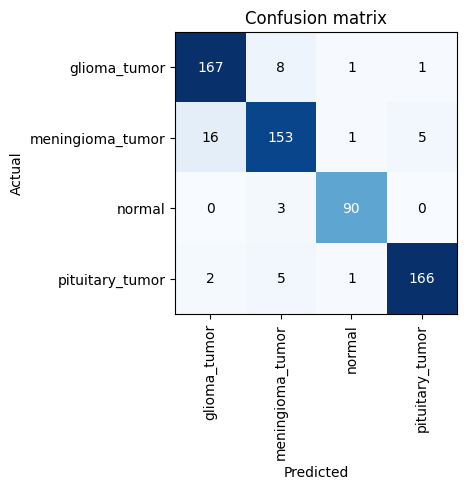

In [ ]:
test_dl = learn.dls.test_dl(test_paths, with_labels=True)

from sklearn.metrics import classification_report, accuracy_score

preds, targets = learn.get_preds(dl=test_dl)
print(f"Preds: {preds}")

pred_classes = preds.argmax(dim=1)
pred_confidences = preds.max(dim=1)[0]

print(f"Predicted classes: {pred_classes}")
print(f"Prediction confidences: {pred_confidences}")
print(f"Average confidence: {pred_confidences.mean().item():.4f}")

unique_classes, counts = torch.unique(pred_classes, return_counts=True)
print("Class distribution in predictions:")
for cls, count in zip(unique_classes.tolist(), counts.tolist()):
    print(f"Class {cls}: {count} ({count/len(pred_classes)*100:.2f}%)")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Average confidence: 0.9346
Accuracy: 0.9484
Class distribution in predictions:
Class 0: 94 (30.32%)
Class 1: 76 (24.52%)
Class 2: 61 (19.68%)
Class 3: 79 (25.48%)

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.94      0.92        90
meningioma_tumor       0.95      0.90      0.92        80
          normal       1.00      1.00      1.00        61
 pituitary_tumor       0.96      0.96      0.96        79

        accuracy                           0.95       310
       macro avg       0.95      0.95      0.95       310
    weighted avg       0.95      0.95      0.95       310



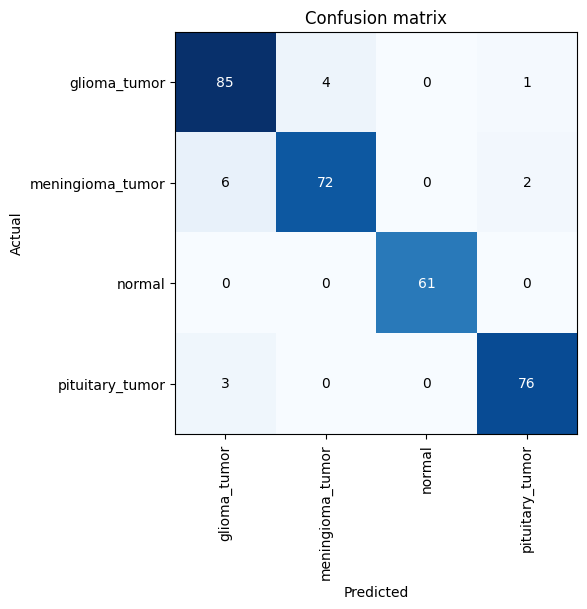

In [ ]:
print(f"Average confidence: {pred_confidences.mean().item():.4f}")
print(f"Accuracy: {accuracy_score(targets, pred_classes):.4f}")

unique_classes, counts = torch.unique(pred_classes, return_counts=True)
print("Class distribution in predictions:")
for cls, count in zip(unique_classes.tolist(), counts.tolist()):
    print(f"Class {cls}: {count} ({count/len(pred_classes)*100:.2f}%)")

class_names = learn.dls.vocab
print("\nClassification Report:")
print(classification_report(targets, pred_classes, target_names=class_names))

interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix(figsize=(6,6))

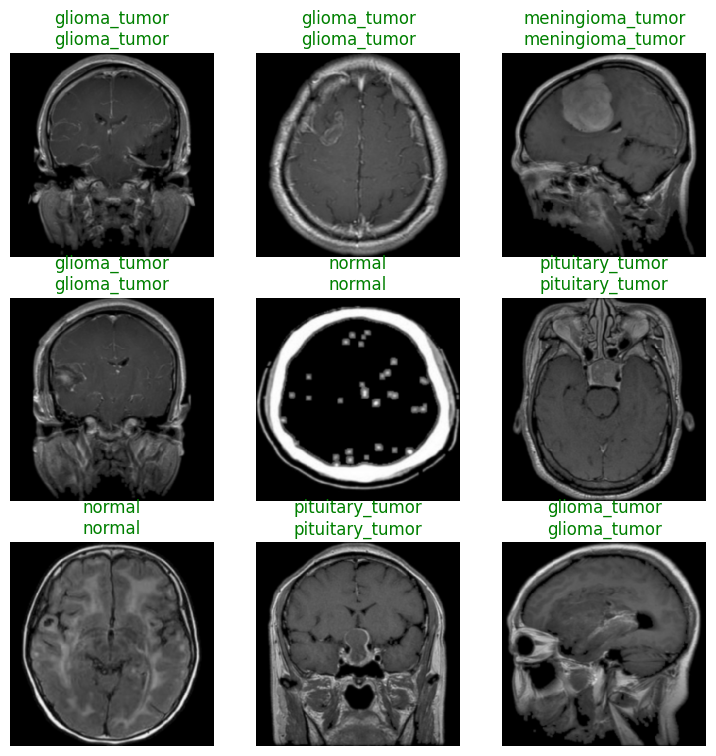

In [ ]:
# resnet50 results
learn.show_results()

In [ ]:
learn.export('/content/drive/MyDrive/model_categoryblock_resnet50_v2.pkl')